# Dataset Profiles

In [1]:
import ROOT
from hep_utils.constants import N_RINGS
from hep_utils.root import get_column_names, rdf_to_pandas, open_vector
from hep_utils import formulas
from lzt_utils.dataset import LztDataset
import hep_utils.plotting.pyplot as hplt
import mplhep as hep
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
ROOT.EnableImplicitMT()
plt.style.use(hep.style.ROOT)

Module libc not found.


Welcome to JupyROOT 6.28/02


In [2]:
dataset = LztDataset.from_dir('/root/data/2024_08_19_21_18_0000000000_single_electron')
output_dir = dataset.makedirs('plots')
ntuple_rdf = dataset.get_ntuple_rdf()
rings_cols, ntuple_rdf = open_vector('rings', N_RINGS, ntuple_rdf)
column_names = get_column_names(ntuple_rdf)
ntuple_pdf = rdf_to_pandas(ntuple_rdf, [name for name in column_names if name != 'rings'], nrows=-1)
print(f"DataFrame shape: {ntuple_pdf.shape}")
ntuple_pdf.head()

DataFrame shape: (10000, 147)


,cluster_deta,cluster_dphi,cluster_e,cluster_e0,cluster_e1,cluster_e2,cluster_e233,cluster_e237,cluster_e277,cluster_e2tsts1,...,rings_90,rings_91,rings_92,rings_93,rings_94,rings_95,rings_96,rings_97,rings_98,rings_99
0,0.2,0.2,1.366081e+06,9.367401,134237.828125,1.229096e+06,1.148022e+06,1.176739e+06,1.219020e+06,14667.642578,...,0.000000,-16.621191,24.922503,-13.953091,13.798578,-11.532078,22.841259,14.733897,-31.352837,23.506092
1,0.2,0.2,7.291899e+05,515.850403,21484.021484,6.960901e+05,6.566786e+05,6.705551e+05,6.912972e+05,1792.068237,...,3.071445,0.000000,30.824715,-75.488609,-48.822529,-6.890697,21.374834,-44.835114,-28.084356,-26.383274
2,0.2,0.2,1.425320e+06,-859.940918,136257.609375,1.287073e+06,1.196545e+06,1.237181e+06,1.275962e+06,17595.925781,...,17.564011,0.000000,26.578655,-1.926748,34.838154,-10.234849,11.156988,-8.000655,0.532772,0.000000
3,0.2,0.2,8.337377e+04,-131.621201,42668.800781,4.079198e+04,3.863341e+04,3.963764e+04,4.095484e+04,5830.453125,...,-10.661143,4.011308,194.460495,54.248878,-321.127319,-81.699821,84.375366,-144.654327,67.681999,-1.230418
4,0.2,0.2,7.978003e+05,612.558289,303018.031250,4.934729e+05,4.499005e+05,4.700538e+05,4.873401e+05,52424.625000,...,3.114481,0.000000,9.449740,-45.740479,-48.621410,-22.805244,0.000000,0.000000,0.000000,0.000000


# Event Aggregation

In [3]:
def ntuple_aggregation(df: pd.DataFrame) -> pd.Series:
    n_objects = len(df)
    if n_objects:
        ordered_idxs = df.index[df['cluster_e'].argsort()][::-1]
        highest_e1 = df.loc[ordered_idxs[0], 'cluster_e']
        highest_e2 = df.loc[ordered_idxs[1], 'cluster_e'] if n_objects > 1 else np.nan
        eta1 = df.loc[ordered_idxs[0], 'el_eta']
        eta2 = df.loc[ordered_idxs[1], 'el_eta'] if n_objects > 1 else np.nan
        phi1 = df.loc[ordered_idxs[0], 'el_phi']
        phi2 = df.loc[ordered_idxs[1], 'el_phi'] if n_objects > 1 else np.nan
    else:
        highest_e1 = np.nan
        highest_e2 = np.nan
        eta1 = np.nan
        eta2 = np.nan
        phi1 = np.nan
        phi2 = np.nan
    return pd.Series({
        'n_objects': n_objects,
        # Plus 1 to account for the event itself
        'n_duplicates': df.duplicated().sum()+1,
        'highest_e1': highest_e1,
        'highest_e2': highest_e2,
        'eta1': eta1,
        'eta2': eta2,
        'phi1': phi1,
        'phi2': phi2
    })
filepath = os.path.join(dataset.path, 'ntuple_grouped_clusters.parquet')
if os.path.exists(filepath):
    ntuple_grouped_clusters = pd.read_parquet(filepath)
else:
    ntuple_grouped_clusters = ntuple_pdf.groupby('event_number').apply(ntuple_aggregation)
    ntuple_grouped_clusters['deltaR'] = formulas.deltaR(ntuple_grouped_clusters['eta1'].values,
                                                    ntuple_grouped_clusters['phi1'].values,
                                                    ntuple_grouped_clusters['eta2'].values,
                                                    ntuple_grouped_clusters['phi2'].values)
    print(f"DataFrame shape: {ntuple_grouped_clusters.shape}")
    ntuple_grouped_clusters.to_parquet(filepath)
ntuple_grouped_clusters.head()

DataFrame shape: (10000, 9)


,n_objects,n_duplicates,highest_e1,highest_e2,eta1,eta2,phi1,phi2,deltaR
event_number,,,,,,,,,
0,1.0,1.0,1.366081e+06,NaN,-1.0125,NaN,-2.6875,NaN,NaN
1,1.0,1.0,7.291899e+05,NaN,-0.2375,NaN,-0.6013,NaN,NaN
2,1.0,1.0,1.425320e+06,NaN,0.8375,NaN,-2.6630,NaN,NaN
3,1.0,1.0,8.337377e+04,NaN,-1.6005,NaN,0.3805,NaN,NaN
4,1.0,1.0,7.978003e+05,NaN,-1.2875,NaN,0.9695,NaN,NaN


# All Rings

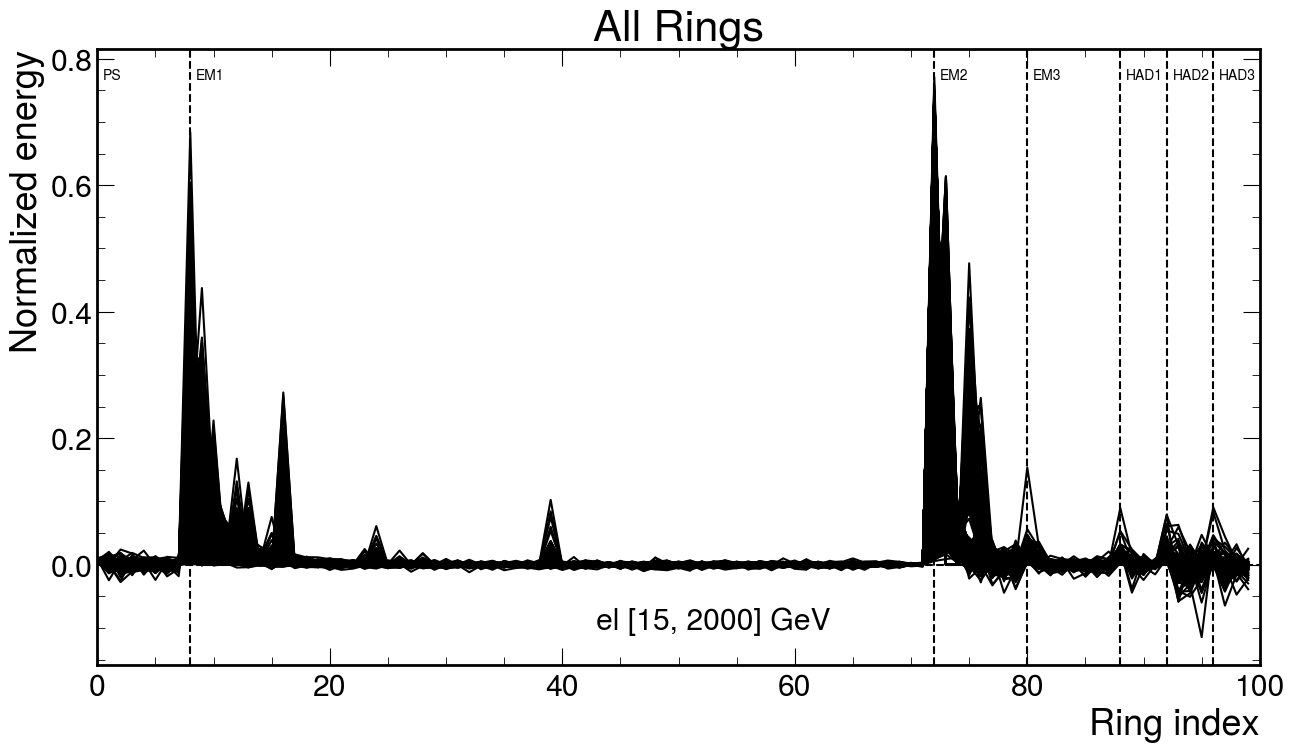

In [4]:
fig, ax = plt.subplots(figsize=(15, 8))
x = np.arange(N_RINGS)
hplt.plot_all_rings(ntuple_pdf[rings_cols], ax, normalize=True, plot_kwargs=dict(color='k'))
ax.plot([], [], ' ', label=dataset.label)
ax.legend()
fig.savefig(os.path.join(output_dir, 'all_rings.png'), bbox_inches='tight', dpi=300)

# Rings Profile

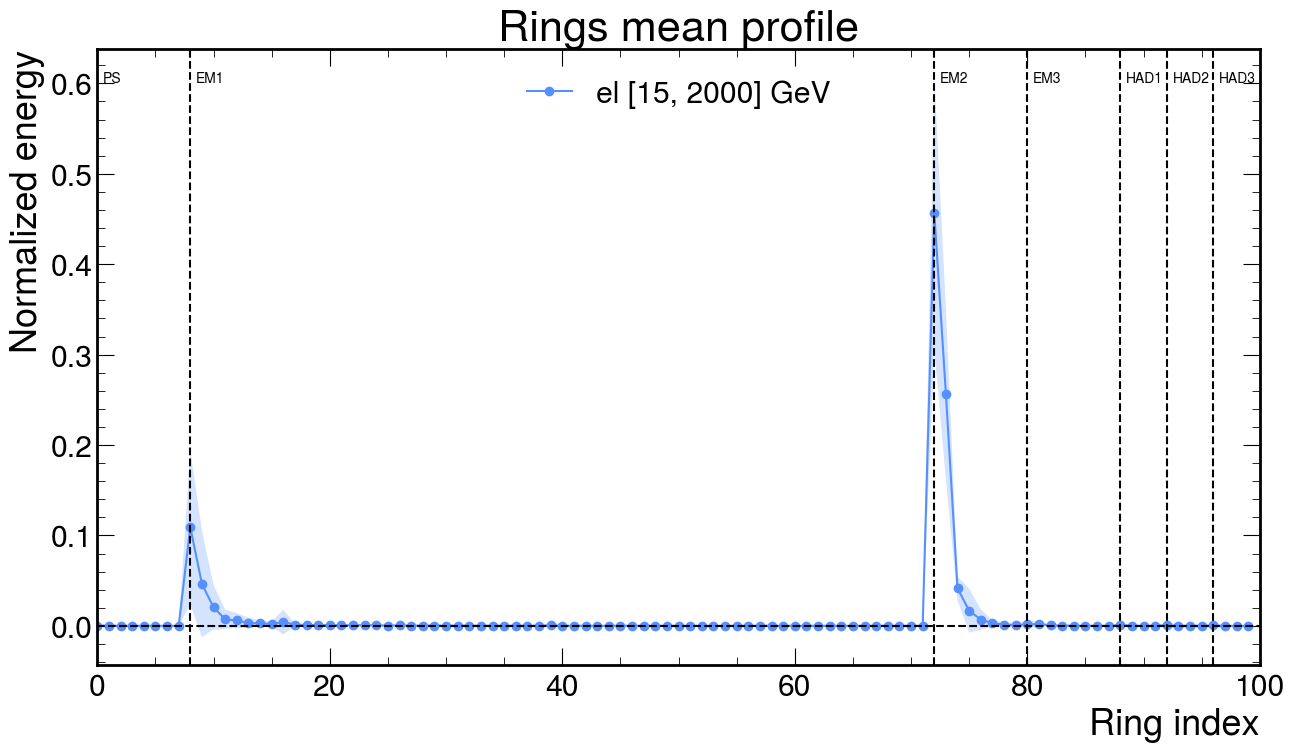

In [5]:
fig, ax = plt.subplots(figsize=(15, 8))
hplt.plot_rings_profile(ntuple_pdf[rings_cols], ax, normalize=True, label=dataset.label)
fig.savefig(os.path.join(output_dir, 'rings_profile_no_normalization.png'), bbox_inches='tight', dpi=300)

# $\Delta R$

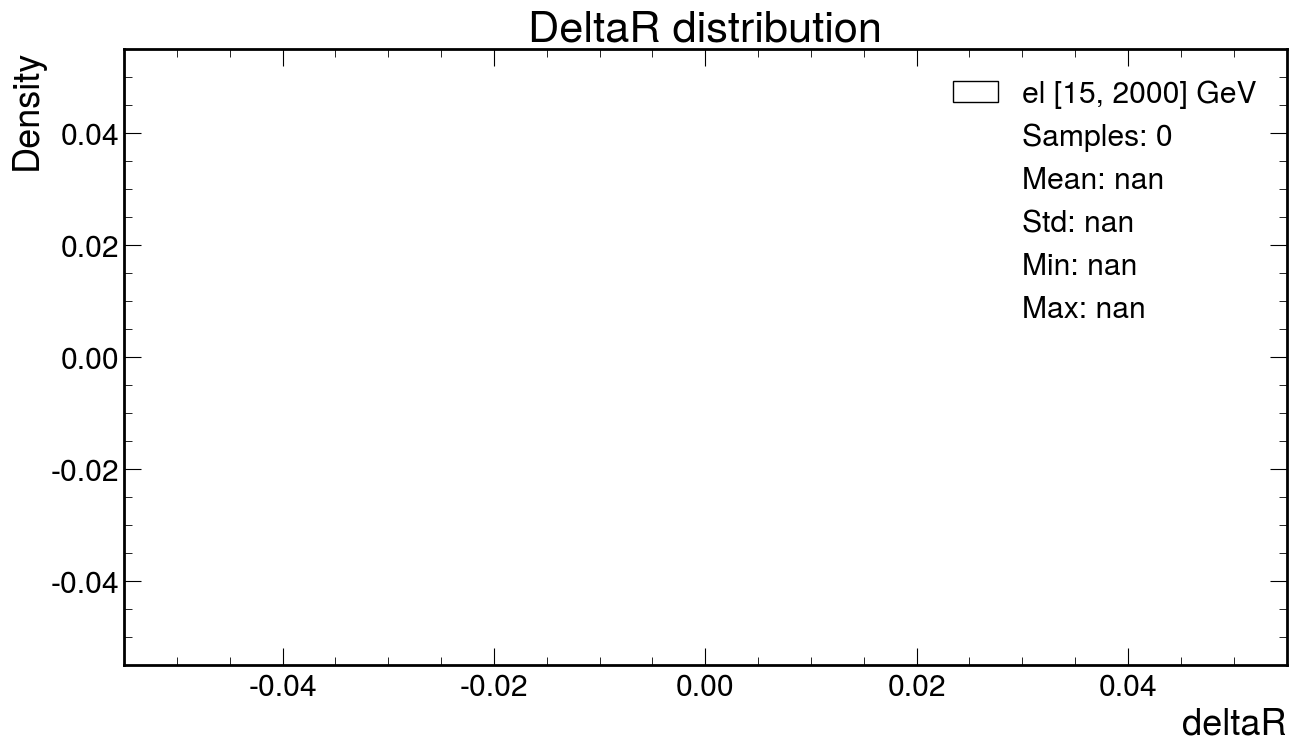

In [6]:
fig, ax = plt.subplots(figsize=(15, 8))
hplt.histplot(
    ntuple_grouped_clusters['deltaR'].dropna(),
    nbins=50,
    ax=ax,
    metrics=True,
    ax_set=dict(
        xlabel='deltaR',
        ylabel='Density',
        title='DeltaR distribution',
    ),
    hist_kwargs=dict(
        histtype='step',
        label=dataset.label,
        color='k',
        density=True
    )
)
fig.savefig(os.path.join(output_dir, 'deltaR_distribution.png'), bbox_inches='tight', dpi=300)

# Object distribution

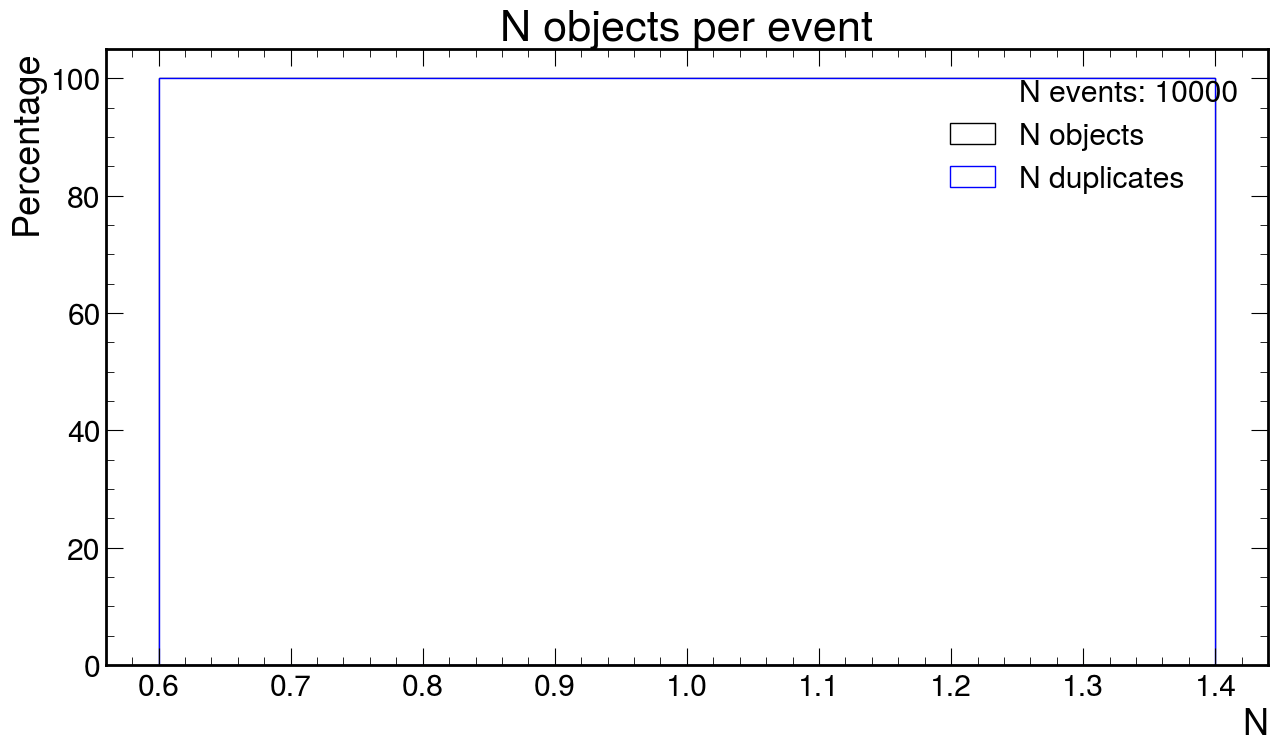

In [7]:
fig, ax = plt.subplots(figsize=(15, 8))
hplt.categorical_histplot(
    ntuple_grouped_clusters['n_objects'].dropna(),
    ax=ax,
    metrics=False,
    percentage=True,
    ax_set=dict(
        xlabel='N',
        ylabel='Percentage',
        title='N objects per event',
    ),
    bar_kwargs=dict(
        label='N objects',
        color='w',
        edgecolor='k'
    )
)
hplt.categorical_histplot(
    ntuple_grouped_clusters['n_duplicates'].dropna(),
    ax=ax,
    metrics=False,
    ax_set=dict(),
    percentage=True,
    bar_kwargs=dict(
        label='N duplicates',
        color='w',
        edgecolor='b'
    )
)
ax.plot([], [], ' ', label=f"N events: {len(ntuple_grouped_clusters)}")
ax.legend()
fig.savefig(os.path.join(output_dir, 'objects_per_event_distribution.png'), bbox_inches='tight', dpi=300)

# Cluster Energy

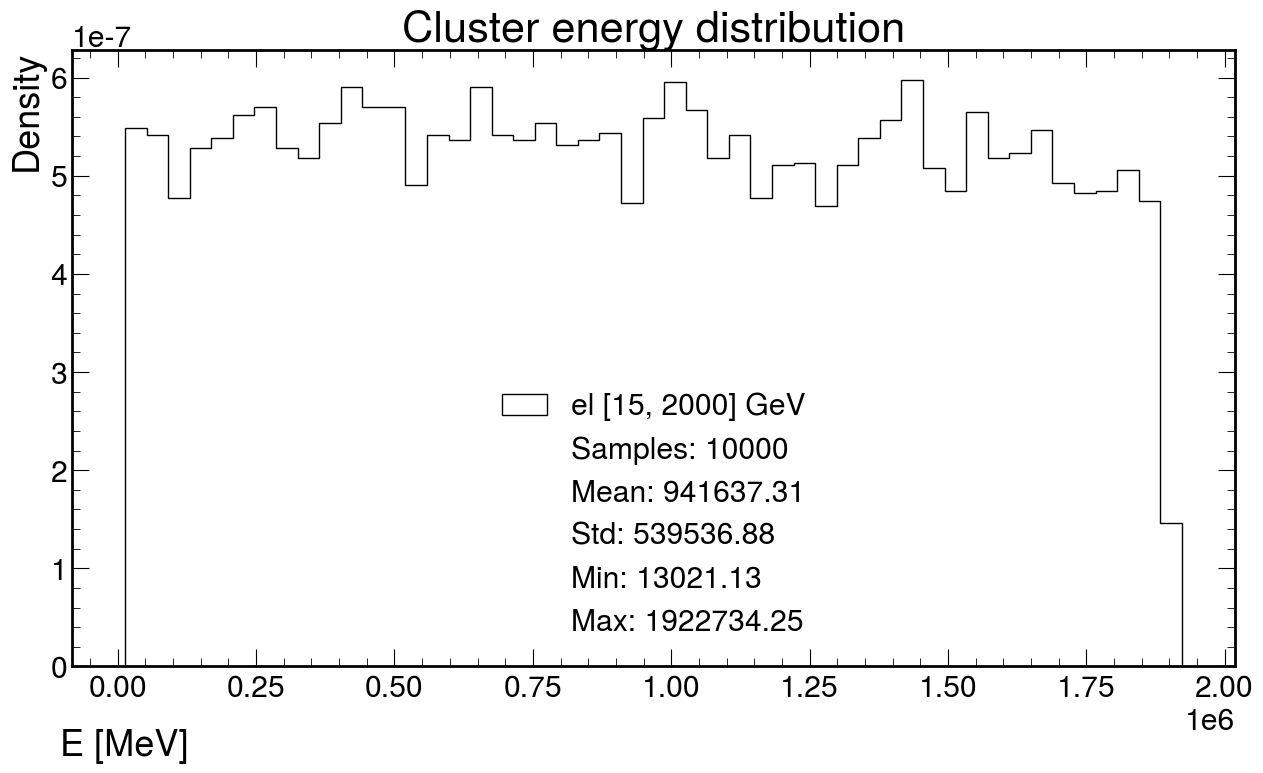

In [8]:
fig, ax = plt.subplots(figsize=(15, 8))
hplt.histplot(
    ntuple_pdf['cluster_e'].dropna(),
    nbins=50,
    ax=ax,
    metrics=True,
    ax_set=dict(
        xlabel='E [MeV]',
        ylabel='Density',
        title='Cluster energy distribution',
    ),
    hist_kwargs=dict(
        histtype='step',
        label=dataset.label,
        color='k',
        density=True
    )
)
ax.xaxis.set_label_coords(0.1, -0.1)
fig.savefig(os.path.join(output_dir, 'cluster_e_distribution.png'), bbox_inches='tight', dpi=300)